In [1]:
# Basic imports
import numpy as np
import pandas as pd

# Machine learning models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, mean_squared_error, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
np.random.seed(42)

In [2]:
# Load data
df = pd.read_csv('../data/Task 3 and 4_Loan_Data.csv')
df = df.set_index('customer_id')
df.head()

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
customer_id,,,,,,,
8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [3]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 8153374 to 5533570
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   credit_lines_outstanding  10000 non-null  int64  
 1   loan_amt_outstanding      10000 non-null  float64
 2   total_debt_outstanding    10000 non-null  float64
 3   income                    10000 non-null  float64
 4   years_employed            10000 non-null  int64  
 5   fico_score                10000 non-null  int64  
 6   default                   10000 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 625.0 KB
None
       credit_lines_outstanding  loan_amt_outstanding  total_debt_outstanding  \
count              10000.000000          10000.000000            10000.000000   
mean                   1.461200           4159.677034             8718.916797   
std                    1.743846           1421.399078             6627.164762   
min          

default
0    0.8149
1    0.1851
Name: proportion, dtype: float64


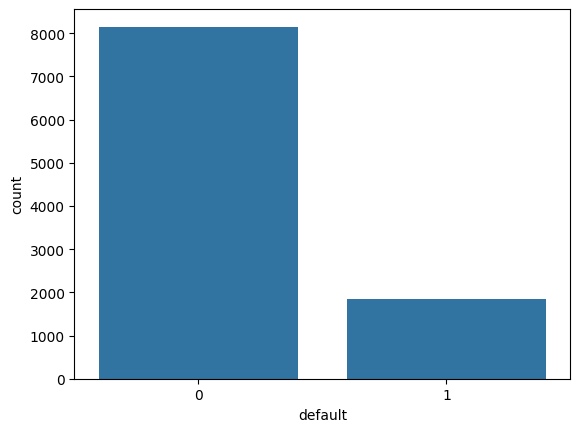

In [4]:
# Check target balance
print(df['default'].value_counts(normalize=True))
sns.countplot(x='default', data=df)
plt.show()

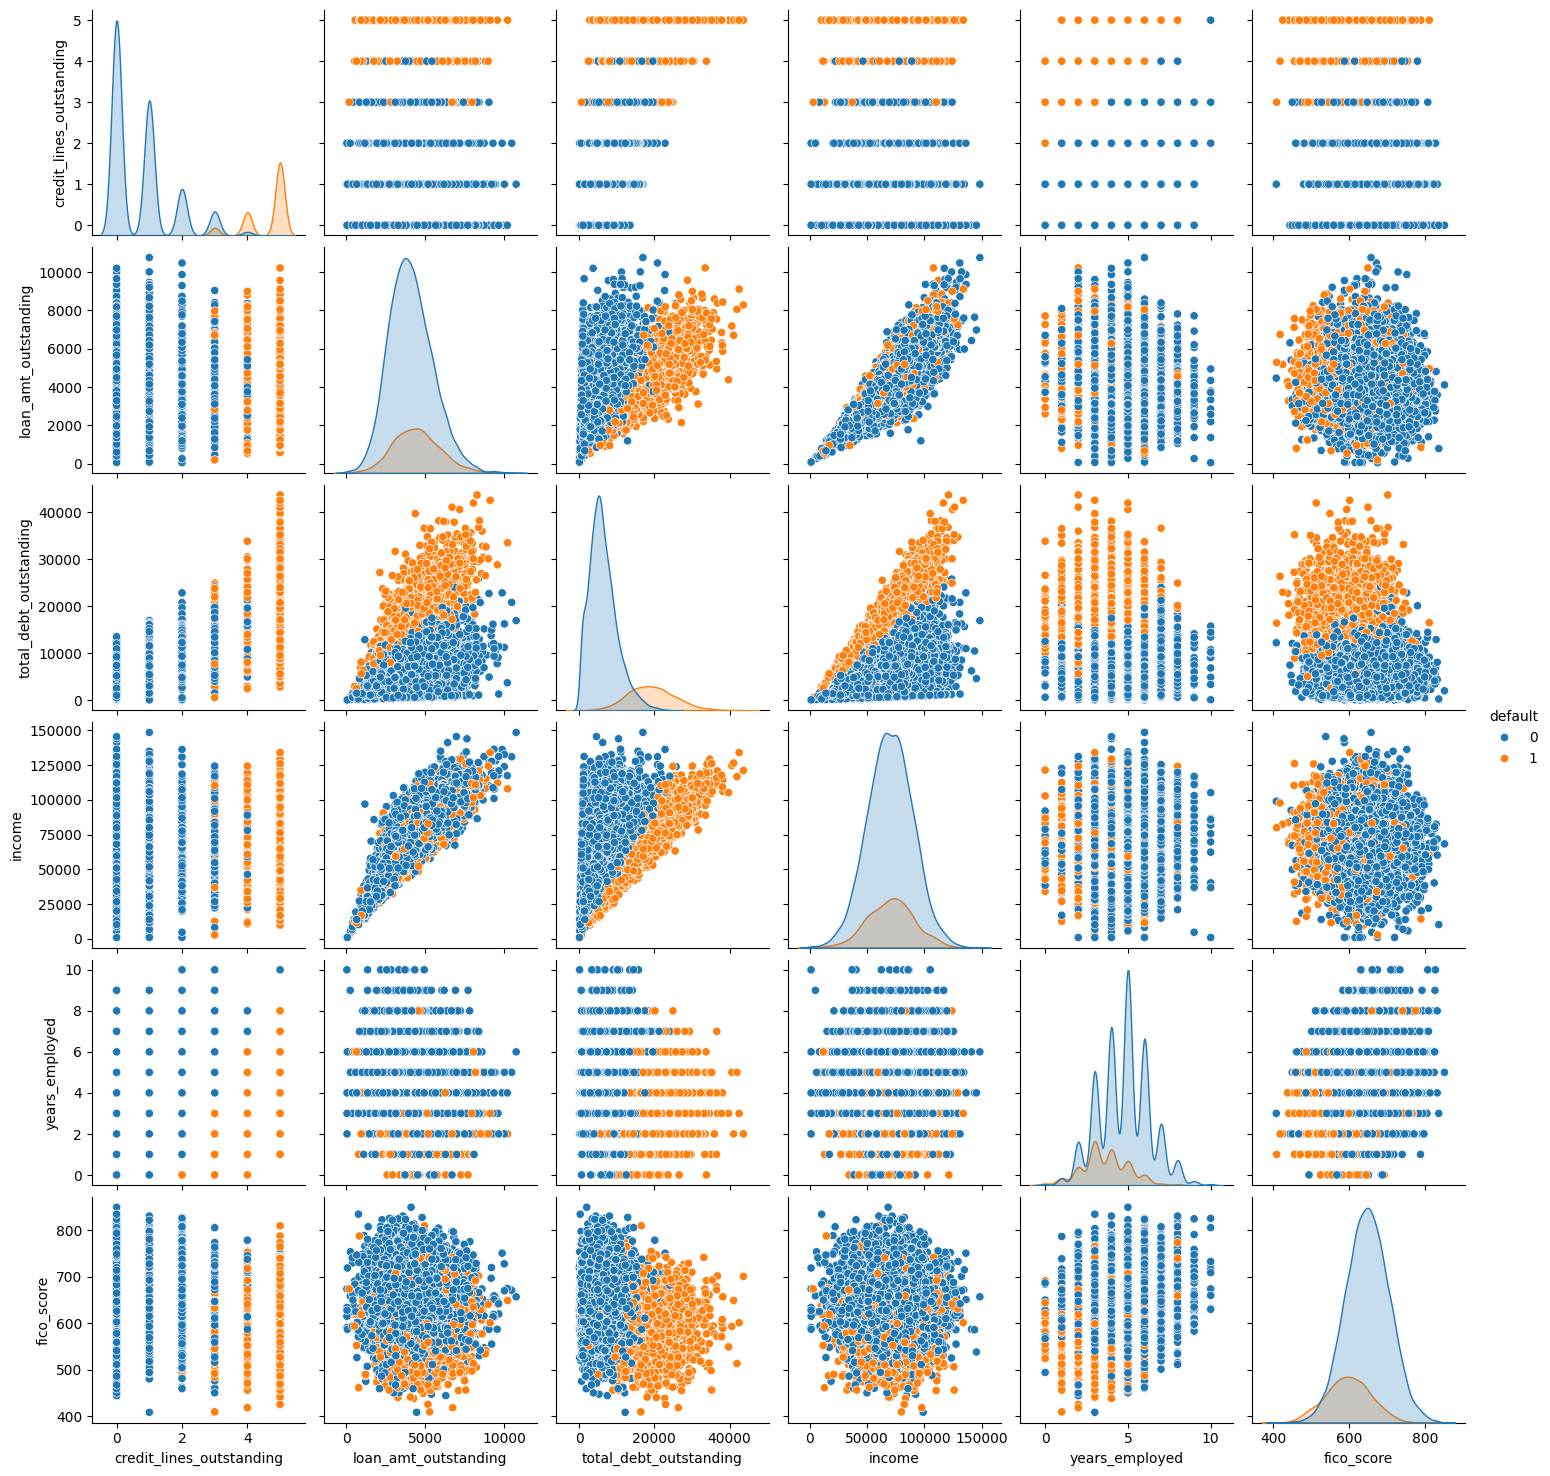

In [5]:
# Exploratory Data Analysis
df.describe()
sns.pairplot(df, hue='default')
plt.show()

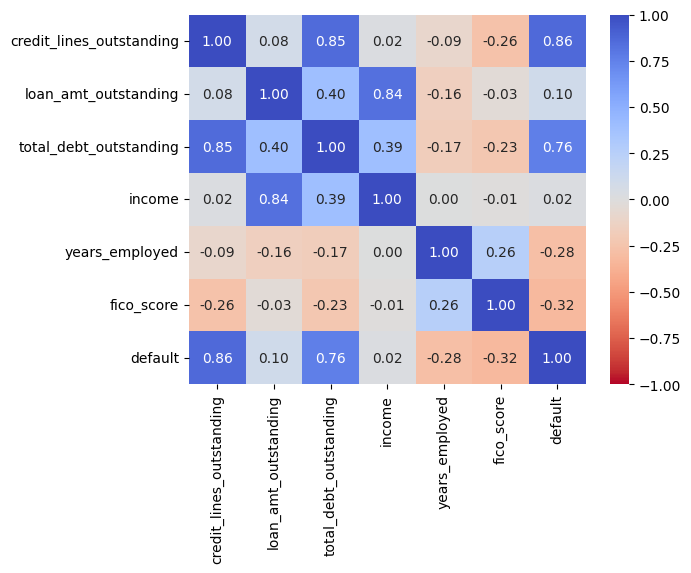

In [6]:
# Correlation heatmap
figsize = (12, 8)
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm_r', vmin=-1, vmax=1)
plt.show()

In [7]:
# Data Preprocessing
X = df.drop(columns=['default'])
y = df['default']

# Train-test split
X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test_df)



In [10]:
# Build models and evaluate
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_proba)
    mse = mean_squared_error(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    results[model_name] = {
        'ROC AUC': roc_auc,
        'MSE': mse,
        'Confusion Matrix': cm
    }

# Display results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"ROC AUC: {metrics['ROC AUC']:.4f}")
    print(f"MSE: {metrics['MSE']:.4f}")
    print("Confusion Matrix:")
    print(metrics['Confusion Matrix'])
    print("-" * 30)

Model: Logistic Regression
ROC AUC: 1.0000
MSE: 0.0010
Confusion Matrix:
[[1630    0]
 [   2  368]]
------------------------------
Model: Decision Tree
ROC AUC: 0.9907
MSE: 0.0050
Confusion Matrix:
[[1626    4]
 [   6  364]]
------------------------------
Model: Random Forest
ROC AUC: 0.9999
MSE: 0.0050
Confusion Matrix:
[[1626    4]
 [   6  364]]
------------------------------
Model: Gradient Boosting
ROC AUC: 0.9999
MSE: 0.0025
Confusion Matrix:
[[1628    2]
 [   3  367]]
------------------------------


In [11]:
def calculate_expected_loss(model, X_input, loan_amount, recovery_rate=0.1):
    pd = model.predict_proba(X_input)[:, 1]  # Probability of Default
    ead = loan_amount                        # Exposure at Default
    lgd = 1 - recovery_rate                  # Loss Given Default
    el = pd * lgd * ead                      # Expected Loss
    return el[0]

# Example
example_loan = X_test[0].reshape(1, -1)
loan_amount = X_test_df.loc[X_test_df.index[0], 'loan_amt_outstanding']
el = calculate_expected_loss(models['Logistic Regression'], example_loan, loan_amount)
print(f"Expected Loss for the example loan: {el:.2f}")


Expected Loss for the example loan: 0.00
